In [3]:
import os
import numpy
from scipy.interpolate import interp1d

root = 'logs/'
algos = ['a2c', 'acktr', 'ppo']
game = 'beamrider'
seeds = [1, 3, 5, 8, 11]
numTrials = 5

def getLogFileNames(trialName):
    folderPath = root + trialName
    logFileNames = [fileName for fileName in os.listdir(folderPath) if 'monitor' in fileName]
    return folderPath, logFileNames
    
def getTrialStats(trialName):
    folderPath, logFileNames = getLogFileNames(trialName)
    #print(folderPath)
    
    logs = []
    for fileName in logFileNames:
        filePath = folderPath + '/' + fileName
        log_lines = []
        with open(filePath, 'r') as log_file:
            log_lines = log_file.readlines()
        logs.append(log_lines[2:])

    numProcesses = len(logs)
    timeSteps = []
    rewards = []
    for log in logs:
        curTimeStep = 0
        for line in log:
            lineParts = line.split(',')
            episodeReward = float(lineParts[0])
            episodeSteps = int(lineParts[1])
            episodeTime = float(lineParts[2])
            curTimeStep += episodeSteps * numProcesses
            timeSteps.append(curTimeStep)
            rewards.append(episodeReward)

    return timeSteps, rewards

def standardize_times(times):
    startTime = times[0]
    endTime = times[-1]
    #numTimes = len(times)
    numTimes = 3000
    return numpy.linspace(startTime, endTime, numTimes)

def standardize_rewards(standardTimes, times, rewards):
    f = interp1d(times, rewards, kind='nearest')
    return f(standardTimes)

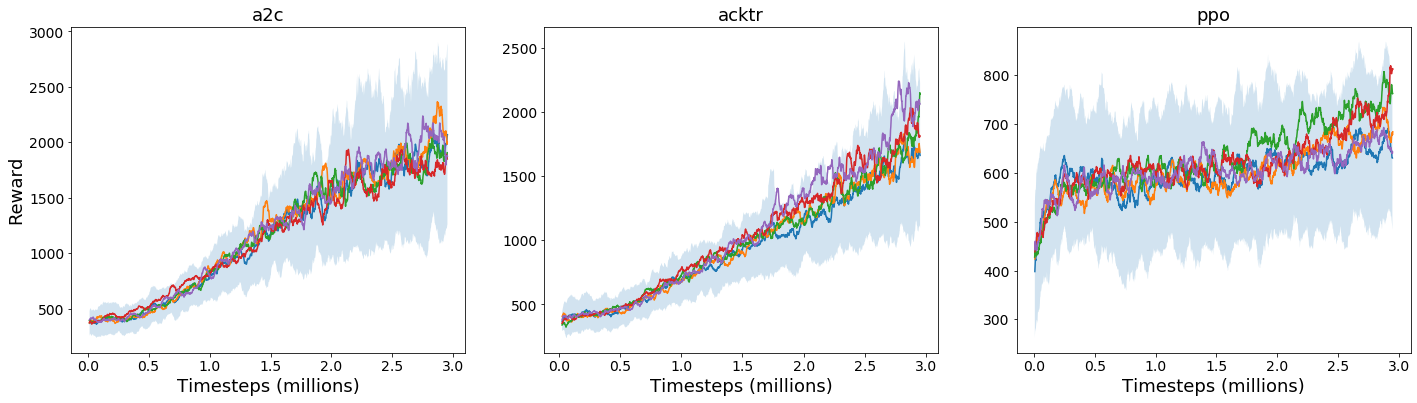

In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 24, 6 #width, height

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig, axs = plt.subplots(1, 3)  
for i, algo in enumerate(algos):
    ax = axs[i]
    ax.set_title(algo, fontsize=18)
    for j, seed in enumerate(seeds):
        standardRewardsList = []
        for trialNum in range(1, numTrials + 1):
            trialNumStr = str(trialNum)
            if seed == 1:
                seedStr = ''
            else:
                seedStr = '_seed' + str(seed)
            trialName = algo + '_' + game + seedStr + '_' + trialNumStr
            times, rewards = getTrialStats(trialName)
            times, rewards = zip(*sorted(zip(times, rewards)))
            lastTime = numpy.argmax(numpy.array(times) > 3e6)
            times = times[:lastTime]
            rewards = rewards[:lastTime]
            standardTimes = standardize_times(times)
            standardRewards = standardize_rewards(standardTimes, times, rewards)
            standardRewardsList.append(standardRewards)
        standardRewardsMat = numpy.array(standardRewardsList)
        rewardsMean = standardRewardsMat.mean(axis=0)
        rewardsError = standardRewardsMat.std(axis=0)
        smoothRewards = running_mean(rewardsMean, 50)
        smoothError = running_mean(rewardsError, 50)
        ax.plot(standardTimes[:-49] / 1e6, smoothRewards)
        if j == 0:
            ax.fill_between(standardTimes[:-49] / 1e6, smoothRewards - smoothError, smoothRewards + smoothError, alpha=0.2)
    ax.set_xlabel('Timesteps (millions)', fontsize=18)
    if i == 0:
        ax.set_ylabel('Reward', fontsize=18) 
    ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.savefig('seed_comparison.png', bbox_inches='tight')
plt.show()

In [10]:
print('\\begin{table}[thb]')
print('\centering')
print('{\small')
print('    \\begin{tabular}{|c|c|c|c|}')
print('    \\hline')
print('    & \multicolumn{3}{c|}{Algorithm} \\\\\cline{2-4}')
print('    Seed  & A2C & ACKTR & PPO \\\\\hline')

for i, seed in enumerate(seeds):
    #ax = axs[i]
    #ax.set_title(game, fontsize=18)
    rowStr = '    ' + str(seed)
    for j, algo in enumerate(algos):
        #standardRewardsList = []
        lastRewards = []
        for trialNum in range(1, numTrials + 1):
            trialNumStr = str(trialNum)
            if seed == 1:
                seedStr = ''
            else:
                seedStr = '_seed' + str(seed)
            trialName = algo + '_' + game + seedStr + '_' + trialNumStr
            times, rewards = getTrialStats(trialName)
            times, rewards = zip(*sorted(zip(times, rewards)))
            cutoffIndex = next(x[0] for x in enumerate(times) if x[1] > 3e6)
            rewards = rewards[:cutoffIndex]
            lastRewards.extend(rewards[-100:])
        lastRewardsArr = numpy.array(lastRewards)
        mean = lastRewardsArr.mean(axis=0)
        std = lastRewardsArr.std(axis=0)
        rowStr += ' & ' + str(int(mean)) + ' $\pm$ ' + str(int(std))
    rowStr += ' \\\ \\hline'
    print(rowStr)

print('    \end{tabular}')
print('    }')
print('    \caption{Mean reward, with standard deviation, for last 100 episodes, taken from 5 trials for each algorithm and seed (including baseline, which is seed 1) trained and evaluated on BeamRider, after 3 million time steps.}')
print('    \label{tbl:seed_comparison}')
print('\end{table}')

\begin{table}[thb]
\centering
{\small
    \begin{tabular}{|c|c|c|c|}
    \hline
    & \multicolumn{3}{c|}{Algorithm} \\\cline{2-4}
    Seed  & A2C & ACKTR & PPO \\\hline
    1 & 1937 $\pm$ 925 & 1647 $\pm$ 760 & 646 $\pm$ 188 \\ \hline
    3 & 2065 $\pm$ 983 & 1698 $\pm$ 813 & 696 $\pm$ 219 \\ \hline
    5 & 1901 $\pm$ 930 & 1810 $\pm$ 905 & 750 $\pm$ 232 \\ \hline
    8 & 1803 $\pm$ 885 & 1862 $\pm$ 900 & 749 $\pm$ 321 \\ \hline
    11 & 2026 $\pm$ 952 & 2044 $\pm$ 1080 & 654 $\pm$ 194 \\ \hline
    \end{tabular}
    }
    \caption{Mean reward, with standard deviation, for last 100 episodes, taken from 5 trials for each algorithm and seed (including baseline, which is seed 1) trained and evaluated on BeamRider, after 3 million time steps.}
    \label{tbl:seed_comparison}
\end{table}
